# [LightGBM](https://github.com/Microsoft/LightGBM)

LightGBM (Light Gradient Boosted Machine) — open source библиотека бустинга, от Microsoft. 

### Что позволяет LightGBM работать быстрее обычного бустинга?

Важный и затратный по времени шаг — построение дерева решений, требующий O(объём данных * кол-во признаков (feature)) времени.<br>
LightGBM использует алгоритмы **GOSS** и **EFB** для его ускорения. Первый уменьшает размер выборки, второй — количество фич.

### **GOSS** — Gradient-based One Side Sampling
Метод уменьшения выборки с учётом градиента. Объекты с маленькими градиентами дают небольшую ошибку, следовательно, экземпляры с большими градиентами сильнее влияют на обучение. Идея GOSS состоит в отбрасывании случайных объектов с небольшими градиентами и перебалансировке оставшейся выборки. 

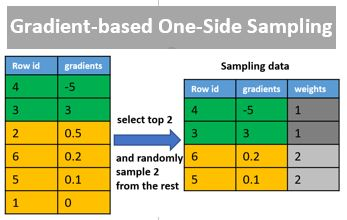

In [4]:
Image('images/goss.jpg')

$X$ - выборка<br>
$a (0 < a < len(X))$ — количество сохраняемых объектов с большими градиентами<br>
$b (0 < b \leq len(X) - a )$ — количество переносящихся в новую выборку объектов с небольшими градиентами

#### Алгоритм:
* Данная выборка сортируется по убыванию градиентов
* Первые $a$ объектов сохраняются в новую выборку
* $b$ случайных объектов из оставшихся $(len(X) - a)$ сохраняются в новую выборку с весами $\frac{len(X) - a}{b}$

По умолчанию LightGBM использует GOSS для первых $\frac{1}{learning\_rate}$ итераций. Чтобы испольховать GOSS на каждой, нужно указать параметр `"boosting" : goss` при создании модели.

### **EFB** — Exclusive Feature Bundling
Количество фич можно значительно сократить, если среди них встречается много взаимоисключающих, не принимающих одновременно нулевые значения признаков. EFB объединяет такие фичи в `bundles`.

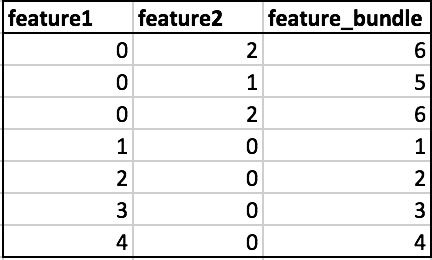

In [5]:
Image('images/efb.png')

Конфликт — количество различных перекрывающихся ненулевых значений.

Алгоритм:
* Заводится массив `bundles` и пороговое значение количества конфликтов `threshold`
* Подсчитываются конфликты между всеми фичами
* Фичи сортируются в порядке убывания количества ненулевых значений
* В цикле по отсортированным фичам:
    - если при добавлении фичи в последний `bundle` конфликт не превышает порога, фича добавляется
    - иначе — в массив кладётся новый `bundle`, куда добавляется фича
Объединение фич внутри каждого `bundle` в одну:
* Рассчитывается такое смещение для каждой из фич, чтобы была биекция между суммой значений со смещениями и первоначальными комбинациями значений фич
* Смещения прибавляются к фичам
* Значения по каждому объекту суммируются

Задача нахождения оптимального объединения фич NP-полная, алгоритм EFB был выбран в результате экспериментов.

EFB используется LightGBM по умолчанию, чтобы отключить его — нужно указать параметр `"enable_bundle" : false` при создании модели.



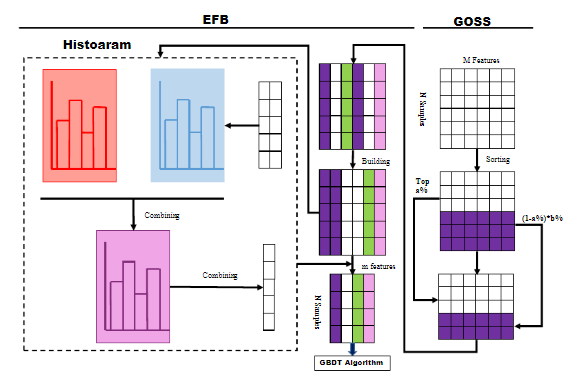

In [3]:
Image('images/full_goss_efb.png')

### Принцип построения дерева решений LightGBM
Многие алгоритмы строят дерево выборов "в ширину", по уровням (`level-wise growth`), тогда как LightGBM — best-first до листьев (**`leaf-wise growth`**). Среди листьев находится тот, углубление по которому приведёт к максимальному уменьшению потери, благодаря этому `leaf-wise`-деревья могут давать меньшие ошибки чем `level-wise`<br>
При таком подходе `One-Hot Encoding` преобразование категориальных фич (замена одной фичи на множество со значениями 1 и 0) может привести к сильному росту дерева в глубину, для контроля глубины дерева есть параметр `max_depth`. LightGBM поддерживает работу с категориальными фичами без использования `One-Hot Encoding`.

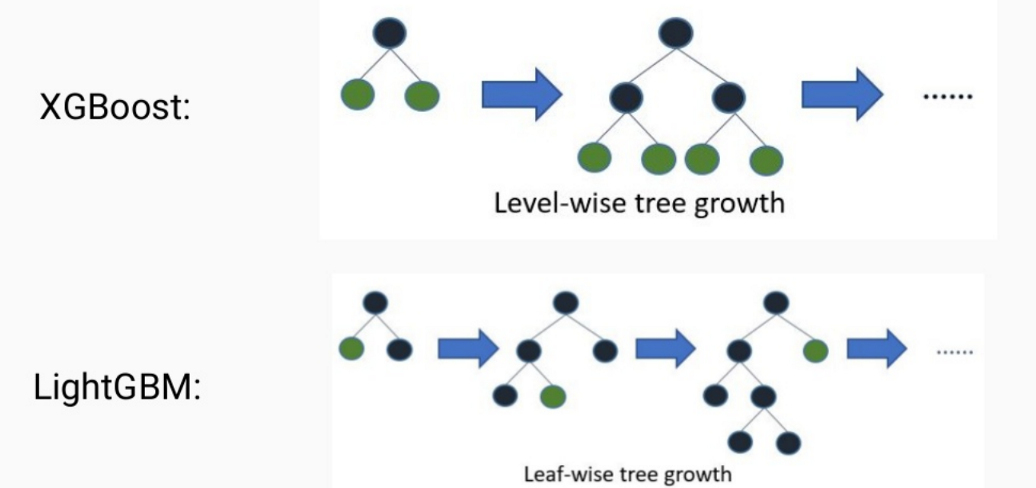

In [ ]:
Image('images/Lwise_growth.png')

## Примеры:

In [235]:
import numpy as np
import lightgbm as lgbm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Примеры классификации:

In [242]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.datasets import load_iris

In [139]:
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
num_classes = len(iris.target_names)

train_dataset = lgbm.Dataset(X_train, y_train, feature_name=iris.feature_names)
test_dataset = lgbm.Dataset(X_test, y_test, feature_name=iris.feature_names)

#### С указанием параметров для классификации:

Подробнее о параметрах в [документации](https://lightgbm.readthedocs.io/en/latest/Parameters.html)

In [145]:
params = {
          "objective" : "multiclass",
          "num_class" : num_classes,
          "num_leaves" : 60,
          "max_depth": -1,           # значение по умолчанию, отсутствие ограничения глубины
          "learning_rate" : 0.01,    # 0.1 по умолчанию
          "verbosity" : -1 }
bst = lgbm.train(params, train_dataset, 100, valid_sets=[train_dataset])

[1]	training's multi_logloss: 1.08212
[2]	training's multi_logloss: 1.06934
[3]	training's multi_logloss: 1.05679
[4]	training's multi_logloss: 1.04446
[5]	training's multi_logloss: 1.03235
[6]	training's multi_logloss: 1.02044
[7]	training's multi_logloss: 1.00873
[8]	training's multi_logloss: 0.997235
[9]	training's multi_logloss: 0.985918
[10]	training's multi_logloss: 0.974789
[11]	training's multi_logloss: 0.963853
[12]	training's multi_logloss: 0.953085
[13]	training's multi_logloss: 0.942492
[14]	training's multi_logloss: 0.93207
[15]	training's multi_logloss: 0.92182
[16]	training's multi_logloss: 0.911724
[17]	training's multi_logloss: 0.901788
[18]	training's multi_logloss: 0.892014
[19]	training's multi_logloss: 0.882383
[20]	training's multi_logloss: 0.872901
[21]	training's multi_logloss: 0.86357
[22]	training's multi_logloss: 0.854373
[23]	training's multi_logloss: 0.845316
[24]	training's multi_logloss: 0.836395
[25]	training's multi_logloss: 0.827612
[26]	training's mul

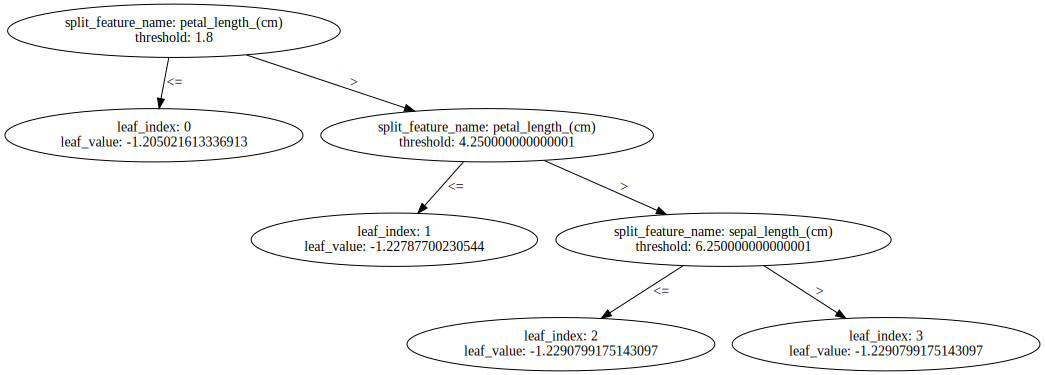

In [146]:
lgbm.create_tree_digraph(bst)

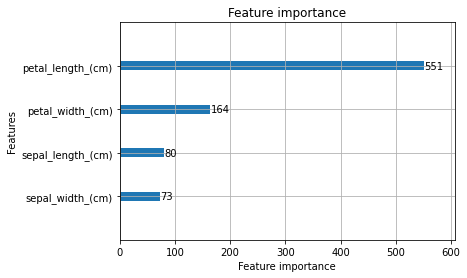

In [147]:
lgbm.plot_importance(bst)

In [148]:
y_pred =np.argmax(bst.predict(X_test),axis=1)
y_pred, y_test

(array([0, 0, 0, 2, 2, 1, 0, 0, 2, 2, 0, 2, 1, 1, 0, 1, 2, 2, 1, 0, 1, 2,
        0, 1, 0, 1, 1, 0, 0, 2, 0, 0, 1, 2, 0, 0, 1, 2]),
 array([0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 2, 1, 1, 0, 1, 2, 1, 1, 0, 2, 2,
        0, 1, 0, 1, 1, 0, 0, 2, 0, 0, 1, 2, 0, 0, 1, 2]))

In [158]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       0.90      0.90      0.90        10
           2       0.91      0.91      0.91        11

    accuracy                           0.95        38
   macro avg       0.94      0.94      0.94        38
weighted avg       0.95      0.95      0.95        38

[[17  0  0]
 [ 0  9  1]
 [ 0  1 10]]


#### Либо с использованием классификатора:

In [156]:
сlassifier = lgbm.LGBMClassifier()
сlassifier.fit(X_train, y_train)
сlassifier_y_pred = сlassifier.predict(X_test)
print(classification_report(y_test, сlassifier_y_pred))
print(confusion_matrix(y_test, сlassifier_y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       0.90      0.90      0.90        10
           2       0.91      0.91      0.91        11

    accuracy                           0.95        38
   macro avg       0.94      0.94      0.94        38
weighted avg       0.95      0.95      0.95        38

[[17  0  0]
 [ 0  9  1]
 [ 0  1 10]]


### Примеры регрессии:

In [279]:
from sklearn.metrics import mean_squared_error

from sklearn.datasets import load_diabetes

def draw_regression(y_test, y_pred):
    x_ax = range(len(y_test))
    plt.figure(figsize=(18, 9))
    plt.plot(x_ax, y_test, label="original")
    plt.plot(x_ax, y_pred, label="predicted")
    plt.title("Diabetes dataset test and predicted data")
    plt.legend(fancybox=True)
    plt.grid(True)
    plt.show() 

In [229]:
diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target
X_train, X_test, y_train, y_test = train_test_split(X, y)

train_dataset = lgbm.Dataset(X_train, y_train)
test_dataset = lgbm.Dataset(X_test, y_test)

#### С указанием параметров:

In [225]:
params = {
    'objective': 'regression',
    'learning_rate': 0.01,
    'num_leaves': 100,
    'verbose': -1
}
model = lgbm.train(params, train_dataset, 1500, valid_sets=[train_dataset])

[1]	training's l2: 5676.12
[2]	training's l2: 5614.75
[3]	training's l2: 5554.61
[4]	training's l2: 5495.66
[5]	training's l2: 5437.89
[6]	training's l2: 5381.26
[7]	training's l2: 5325.76
[8]	training's l2: 5271.37
[9]	training's l2: 5219.45
[10]	training's l2: 5167.96
[11]	training's l2: 5118.06
[12]	training's l2: 5068.55
[13]	training's l2: 5020.56
[14]	training's l2: 4972.95
[15]	training's l2: 4926.3
[16]	training's l2: 4881.04
[17]	training's l2: 4836.18
[18]	training's l2: 4792.21
[19]	training's l2: 4749.54
[20]	training's l2: 4706.18
[21]	training's l2: 4664.22
[22]	training's l2: 4622.2
[23]	training's l2: 4582.07
[24]	training's l2: 4541.63
[25]	training's l2: 4504.18
[26]	training's l2: 4465.54
[27]	training's l2: 4428.36
[28]	training's l2: 4390.86
[29]	training's l2: 4356.08
[30]	training's l2: 4319.95
[31]	training's l2: 4285.48
[32]	training's l2: 4250.71
[33]	training's l2: 4217.97
[34]	training's l2: 4185.17
[35]	training's l2: 4153.01
[36]	training's l2: 4120.88
[37

In [240]:
y_pred = model.predict(X_test)
print(mean_squared_error(y_test, y_pred))
print(y_test)
print(y_pred)

1070.4026726227303
[202.  78.  78.  83. 144. 166.  67. 253.  77. 280. 143. 118. 129. 200.
  97. 184.  89.  80.  51. 272. 111. 178. 200. 144. 150.  77.  66.  53.
 174. 104.  47.  74. 220.  52. 182. 259.  66.  95. 199.  72. 249. 202.
  72. 163. 142. 127.  95. 244.  49. 248.  91. 142. 116.  64. 173. 317.
 235. 182. 262. 201. 150. 131. 160. 197. 219. 233.  67. 121. 214.  84.
 232. 142. 243. 125.  93. 177. 143. 138. 220. 104. 210.  94. 295.  48.
  42. 281.  85.  50.  44. 186. 110. 108. 139. 135. 206. 182. 208. 246.
  84. 141. 252. 114. 150.  72. 245.  90. 113. 252.  52. 268.  64.]
[178.27368384  97.18000707  80.27581178 119.33057141 172.42087183
 170.31562015 117.85189556 121.42786244  73.68928788 281.13520973
 146.1276401  117.69346148 144.24098542 177.17832696  90.13333596
 177.52239827 121.09282917  81.2245748   48.41792882 223.18960618
 107.78102048 158.95757801 193.18433996 143.02969946 150.07261813
  60.97760117  89.81889357  59.81636235 177.64745943 109.85830632
  82.80786901  81.954

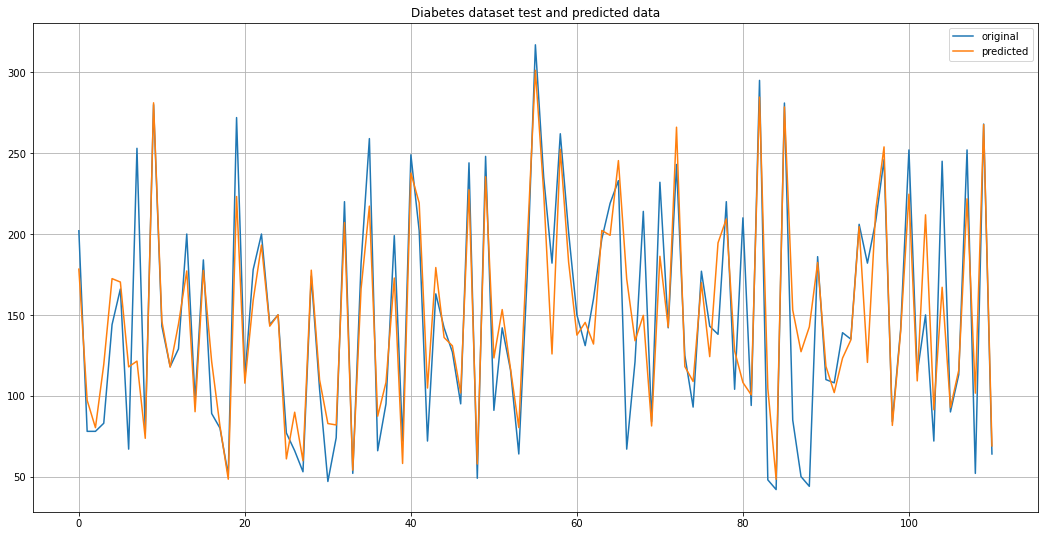

In [280]:
draw_regression(y_test, y_pred)

#### С использованием регрессора:

3374.2091460397787


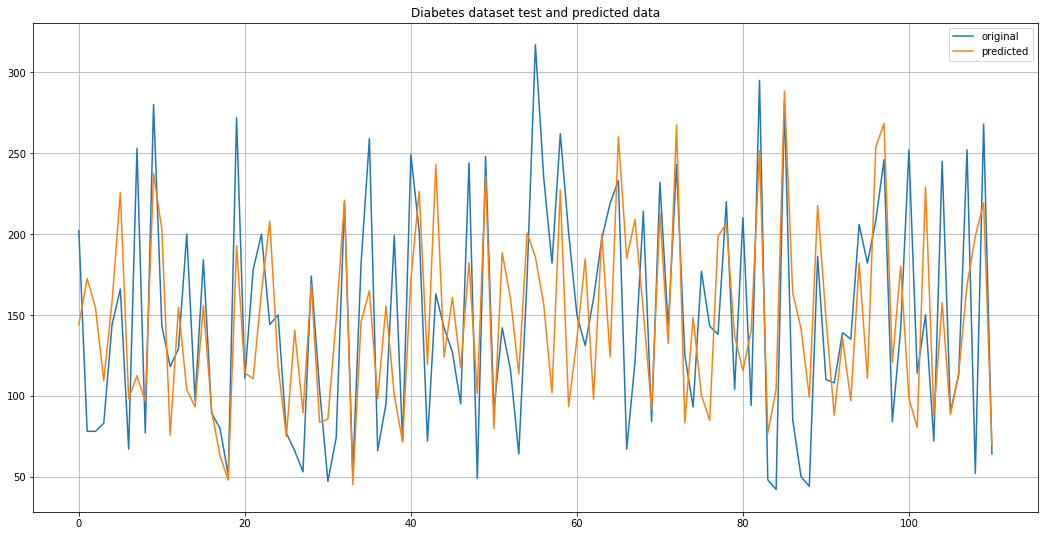

In [281]:
model = lgbm.LGBMRegressor(learning_rate=0.08, n_estimators=50, min_child_weight=0.01)
model.fit(X_train, y_train)
regressor_y_pred = model.predict(X_test)
print(mean_squared_error(y_test, regressor_y_pred))
draw_regression(y_test, regressor_y_pred)

## Ссылки

[Документация](https://lightgbm.readthedocs.io/en/v3.3.2/index.html)<br>
[Статья об оптимизациях LightGBM (GOSS и EFB)](https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf)<br>
[Статья на Хабре с исследованием деревьев и скорости обучения](https://habr.com/ru/company/skillfactory/blog/530594/)